# Imports

In [19]:
import LightPipes as lp
import numpy as np
import matplotlib.pyplot as plt

# Functions

In [20]:
def plot_Field(Field: lp.field.Field, cmap="jet", title="Field", gridimg=False) -> None:
    """
        Given an intensity array I and the extent (in mm) of the image, plot it and its intensity through the middle.
    """
    # Get the intensity
    I = lp.Intensity(Field, flag=0)

    # Get the size
    size = Field.siz

    # Array size
    N = Field.N

    # Setup subplots
    cols = 2
    rows = 1
    plt.figure(figsize=(6 * cols, 5 * rows))

    # Plot the field image
    plt.subplot(rows, cols, 1)
    plt.imshow(I, extent=(0, size / lp.mm, 0, size / lp.mm), cmap=cmap)
    plt.colorbar()
    plt.title(title + f" N={N}")
    plt.xlabel('Position (mm)')
    plt.ylabel('Position (mm)')
    if gridimg:
        plt.grid("on")

    # Plot the field Intensity
    plt.subplot(rows, cols, 2)
    xx = (np.arange(N)/N * size - (size / 2))

    plt.plot(xx * (1/lp.mm), I[N//2], label="Simulation")
    plt.title("Intensity profile through the center")
    plt.xlabel("x position (mm)")
    plt.ylabel("Intensity (a.u.)")
    plt.grid("on")

In [27]:
# Generate ABCD matrices
def ABCDspace(d: float, n: float) -> np.ndarray:
    return np.array([[1, d/n], [0, 1]])


def ABCDlens(f: float) -> np.ndarray:
    return np.array([[1, 0], [-1/f, 1]])

In [28]:
# Get beam parameters from ABCD matrix
def beamWaist(ABCD: np.ndarray, w0: float, wave: float) -> float:
    zr = np.pi * w0**2 / wave
    return np.sqrt(w0**2 * ((ABCD[0, 1]**2 + ABCD[0, 0]**2 * zr**2) / zr**2))

def beamRadius(ABCD: np.ndarray, w0: float, wave: float) -> float:
    zr = np.pi * w0**2 / wave
    return (ABCD[0, 1]**2 + ABCD[0, 0]**2 * zr**2) / (ABCD[0, 1] * ABCD[1, 1] + ABCD[0, 0] * ABCD[1, 0] * zr**2)

In [29]:
# Generate beam intensities
def intensityGauss(r: np.ndarray, w0:float, w: float):
    return (w0/w)**2 * np.exp(-2 * (r/w)**2)

def intensityTotal(r: np.ndarray, w0: float, w1: float, w2: float, R1: float, R2: float, C1: float, C2: float, opd: float, k: float) -> np.ndarray:
    # Phase difference
    delta = k * (opd + r**2 / (2*R2) - r**2 / (2*R1))

    # Intensities of each beam
    I1 = intensityGauss(r, w0, w1) * np.abs(C1)
    I2 = intensityGauss(r, w0, w2) * np.abs(C2)
    
    # Total intensity
    return I1 + I2 + 2 * np.sqrt(I1 * I2) * np.cos(delta)

# Original Code

Original code taken from [LightPipes](https://opticspy.github.io/lightpipes/MichelsonInterferometer.html).

In [21]:
# Laser Parameters
w0 = 7 * lp.mm # laser beam radius
wave = 632.8 * lp.nm #wavelength of HeNe laser


# Setup Parameters
z1 = 8 * lp.cm # length of arm 1
z2 = 7 * lp.cm # length of arm 2
z3 = 3 * lp.cm # distance laser to beamsplitter
z4 = 5 * lp.cm # distance beamsplitter to screen

Rbs = 0.5 # reflection beam splitter

tx = 0 * lp.mrad # tilt of mirror 1
ty = 0 * lp.mrad # tilt of mirror 1

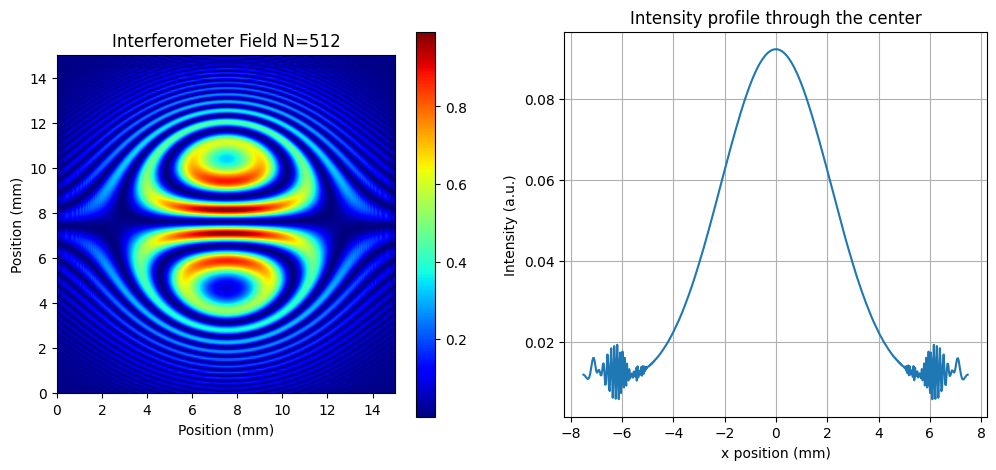

In [22]:
# Simulation Parameters
size = 15 * lp.mm # size of the grid
N = 2**9 # number (NxN) of grid pixels


# Generate a weak converging laser beam using a weak positive lens:
Field = lp.Begin(size, wave, N)
Field = lp.GaussBeam(Field, w0)

#Propagate to the beamsplitter:
Field = lp.Forvard(Field, z3)

#Split the beam and propagate to mirror #2:
Field2 = lp.IntAttenuator(Field, 1-Rbs)
Field2 = lp.Forvard(Field2, z2)

#Introduce aberration and propagate back to the beamsplitter:
Field2 = lp.Tilt(Field2, tx, ty)
Field2 = lp.Zernike(Field2, 3, -1, 6 * lp.mm, A = 1.03*wave)
Field2 = lp.Forvard(Field2, z2)
Field2 = lp.IntAttenuator(Field2, Rbs)

#Split off the second beam and propagate to- and back from the mirror #1:
Field1 = lp.IntAttenuator(Field, Rbs)
Field1 = lp.Forvard(Field1, z1*2)
Field1 = lp.IntAttenuator(Field1, 1-Rbs)

#Recombine the two beams and propagate to the screen:
Field = lp.BeamMix(Field1, Field2)
Field = lp.Forvard(z4, Field)
I = lp.Intensity(1, Field)

# Draw the Field in 2D
I = lp.Intensity(Field, flag=0)

plot_Field(Field, title="Interferometer Field")
plt.show()


# Adding a lens

In [34]:
def michelsonLens(N: int, size: float, f: float) -> None:
    global w0, wave, z1, z2, z3, z4, Rbs, tx, ty

    # Generate a weak converging laser beam using a weak positive lens:
    Field = lp.Begin(size, wave, N)
    Field = lp.GaussBeam(Field, w0)

    # Propagate to the beamsplitter:
    Field = lp.Forvard(Field, z3)

    # Split the beam and propagate to mirror #2:
    Field2 = lp.IntAttenuator(Field, 1-Rbs)
    Field2 = lp.Forvard(Field2, z2/2)
    Field2 = lp.Lens(Field2, f)
    Field2 = lp.Forvard(Field2, z2/2)

    # Propagate back to the beamsplitter:
    Field2 = lp.Tilt(Field2, 0, 0)
    Field2 = lp.Forvard(Field2, z2/2)
    Field2 = lp.Lens(Field2, f)
    Field2 = lp.Forvard(Field2, z2/2)
    Field2 = lp.IntAttenuator(Field2, Rbs)

    # Split off the second beam and propagate to and back from the mirror #1:
    Field1 = lp.IntAttenuator(Field, Rbs)
    Field1 = lp.Forvard(Field1, z1*2)
    Field1 = lp.IntAttenuator(Field1, 1-Rbs)

    # Recombine the two beams and propagate to the screen:
    Field = lp.BeamMix(Field1, Field2)
    Field = lp.Forvard(z4, Field)

    # Draw the Field in 2D
    plot_Field(Field, title="Interference Pattern")
    plt.show()

    return

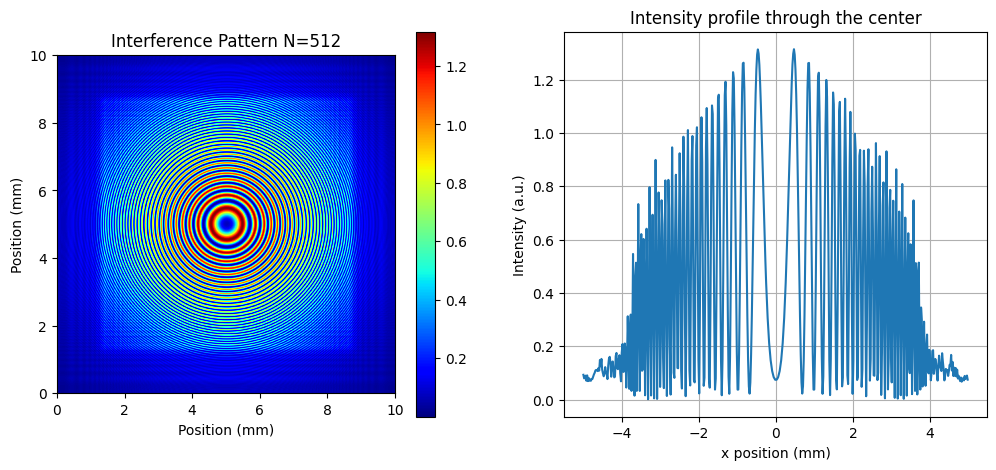

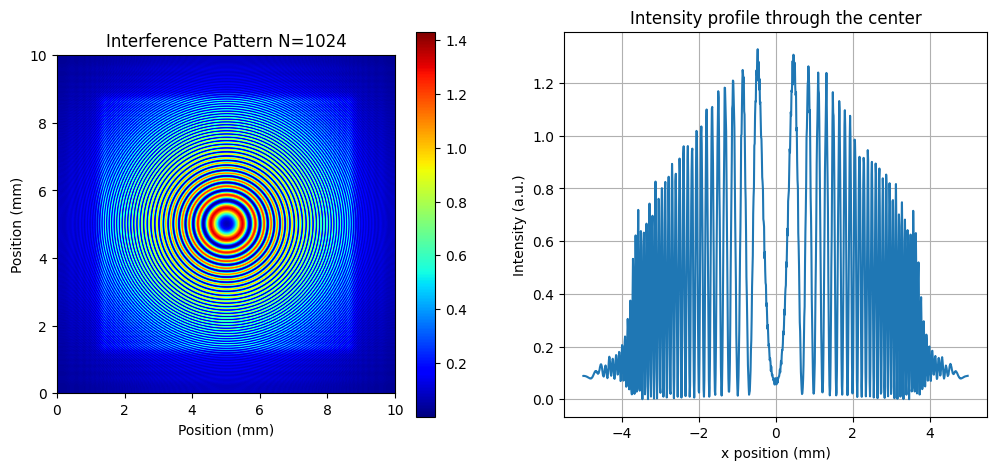

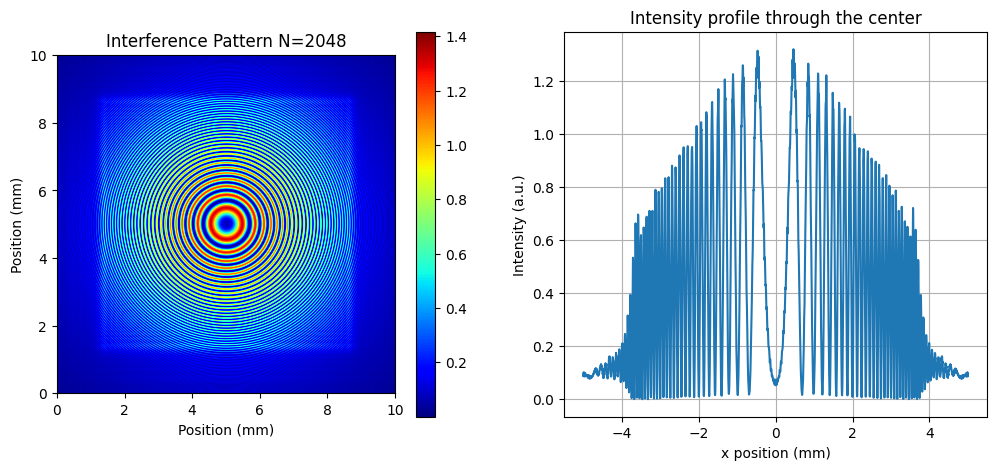

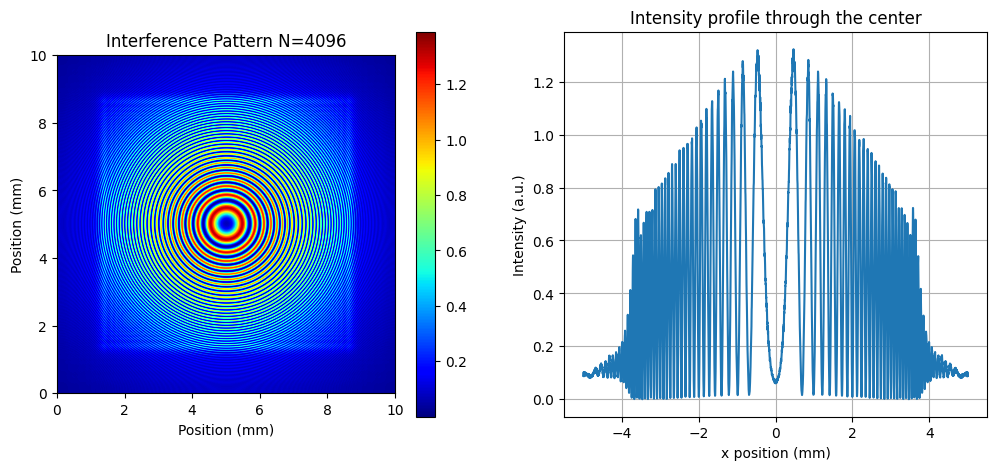

In [37]:
# Simulation Parameters
N = 2**9 # number (NxN) of grid pixels
size = 10 * lp.mm # size of the grid


# Lens focal distance
f = 1 * lp.m


michelsonLens(N, size, f)
michelsonLens(2*N, size, f)
michelsonLens(4*N, size, f)
michelsonLens(8*N, size, f)

# Theory

In [ ]:
# Matrix for beam 1
ABCD1 = ABCDspace(L2, 1) @ ABCDlens(f) @ ABCDspace(2 * L0, 1) @ ABCDlens(f) @ ABCDspace(z3 + 2*z2, 1)
ABCD2 = ABCDspace(L2, 1) @ ABCDlens(f) @ ABCDspace(2 * (L0 + (d-d0)/n0 + d0/n), 1) @ ABCDlens(f) @ ABCDspace(L1, 1)

# Beam parameters
w1, R1 = beamWaist(ABCD1, w0, wave), beamRadius(ABCD1, w0, wave)
w2, R2 = beamWaist(ABCD2, w0, wave), beamRadius(ABCD2, w0, wave)

# Check against the paper calculations
A1 = 2 * (1 - L0/f)*(1 - L2/f) - 1
B1 = (1-L1/f) * (2 * L0 * (1 - L2/f) + L2) + L1 * (1 - L2/f)
C1 = -2 * (1 - L0/f) / f
D1 = 2 * (1 - L0/f) * (1 - L1/f) - 1

ABCD1check = np.array([[A1, B1], [C1, D1]])

print(np.array_str(ABCD1, precision=4))
print(np.array_str(ABCD1check, precision=4))

print("\n")

A2 = 2 * (1 - (L0 + d0/n + (d - d0)/n0)/(f)) * (1 - L2/f) - 1
B2 = (1 - L1/f) * (2 * (L0 + d0/n + (d - d0)/n0) * (1 - L2/f) + L2) + L1 * (1 - L2/f)
C2 = -2/f * (1 - (L0 + d0/n + (d-d0)/n0)/(f))
D2 = 2 * (1 - (L0 + d0/n + (d - d0)/n0)/(f)) * (1 - L1/f) - 1

ABCD2check = np.array([[A2, B2], [C2, D2]])

print(np.array_str(ABCD2, precision=4))
print(np.array_str(ABCD2check, precision=4))

# R1 /= 4
# R2 /= 4

# Show beam waists and radii
print("\n")
print(f"Beam waists (mm): w1 = {w1/lp.mm:.3f} & w2 = {w2/lp.mm:.3f}")
print(f"Beam radii (mm): R1 = {R1/lp.mm:.3f} & R2 = {R2/lp.mm:.3f}")


# Generate intensity values
NInt = 2000
rr = np.linspace(-size/2, size/2, NInt)
ii = intensityTotal(rr, w0, w1, w2, R1, R2, T, T * (1-T)**2, opd, k)


# Rescale to Field intensity
I = lp.Intensity(Field, flag=0)
ii *= max(I[N//2]) / max(ii)

# View our intensity and compare it to last simulation
plot_Field(Field, cmap="jet", title="Field at the detector")
plt.plot(rr/lp.mm, ii, label="Theory", lw=1)
plt.legend()
plt.show()